In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xg
%matplotlib inline

In [4]:
# Get current working directory
current_dir = os.getcwd()

# Move one level up (parent directory)
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

In [5]:
data = pd.read_csv("Data/German Credit/data/german_credit_data.csv")

In [6]:
from sklearn.preprocessing import LabelEncoder

for col in data.select_dtypes(include='object').columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [7]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category')

In [8]:
X = data.drop('target', axis=1)
y = data['target']

In [9]:
y[y == 2] = 0
y[y == 1] = 1

In [10]:
data_dmatrix = xg.DMatrix(data=X,label=y, enable_categorical=True)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## XGBoost Tree Structure

In [12]:
from xgboost import XGBClassifier


# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100, 
        }
            
            
            
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)



# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=1.0, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, ...)

In [13]:
y_pred_xgb = xgb_clf.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score

print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_xgb)))

XGBoost model accuracy score: 0.7533


In [15]:
from xgboost import cv

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [16]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.663399,0.019136,0.619497,0.015004
1,0.776286,0.020588,0.731160,0.029383
2,0.789074,0.019903,0.736479,0.017155
3,0.808842,0.016000,0.756448,0.016501
4,0.820593,0.019706,0.760046,0.020611


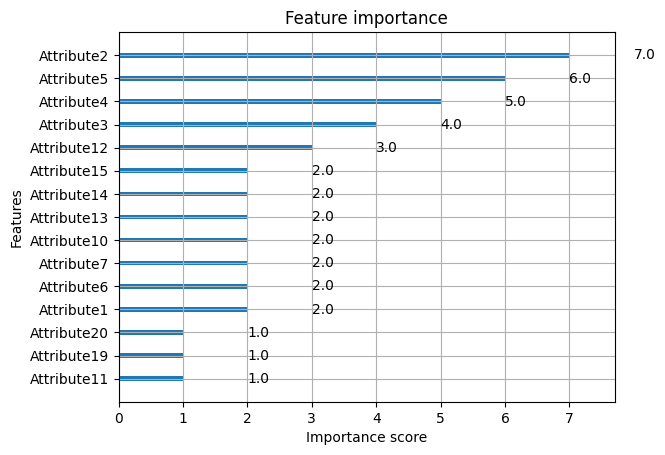

In [17]:
xg.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

In [18]:
from sklearn.inspection import permutation_importance

result = permutation_importance(xgb_clf, X_train, y_train, n_repeats=10, random_state=42)

# View the results
import pandas as pd

perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

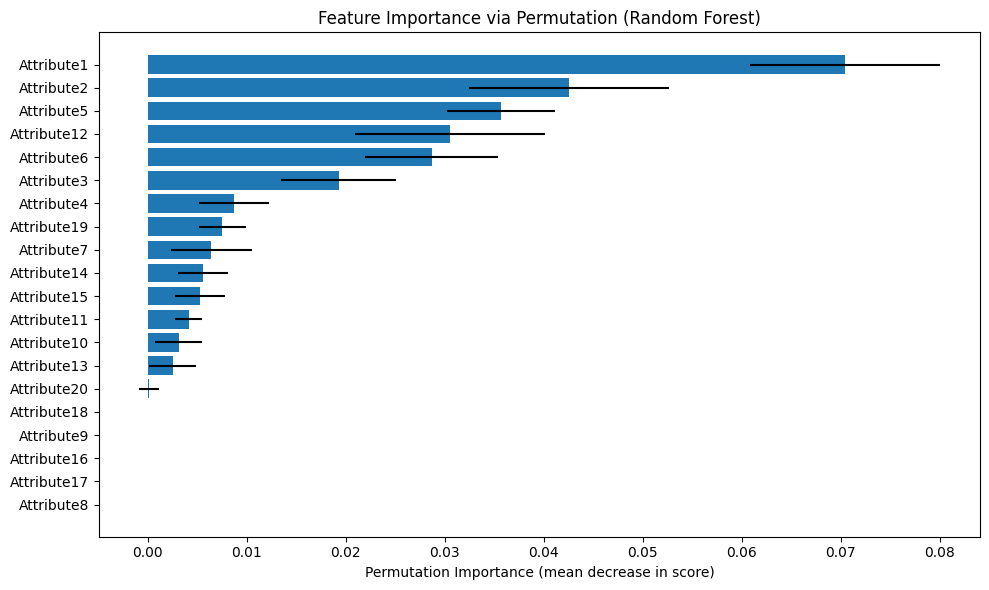

In [19]:
perm_df_sorted = perm_df.sort_values(by='Importance Mean', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(perm_df_sorted['Feature'], perm_df_sorted['Importance Mean'], xerr=perm_df_sorted['Importance Std'])
plt.xlabel('Permutation Importance (mean decrease in score)')
plt.title('Feature Importance via Permutation (Random Forest)')
plt.tight_layout()
plt.show()


## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
y_pred_rf = rf_classifier.predict(X_test)

In [22]:
print('Random Forest model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_rf)))

Random Forest model accuracy score: 0.7767


In [23]:
importances = rf_classifier.feature_importances_

# Create a DataFrame for better viewing
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

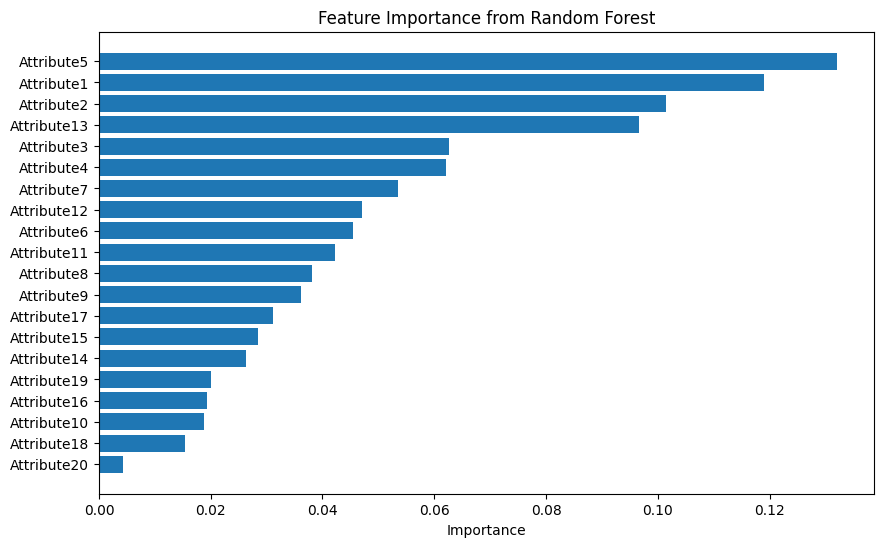

In [24]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()  # highest importance on top
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

In [25]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf_classifier, X_train, y_train, n_repeats=10, random_state=42)

# View the results
import pandas as pd

perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

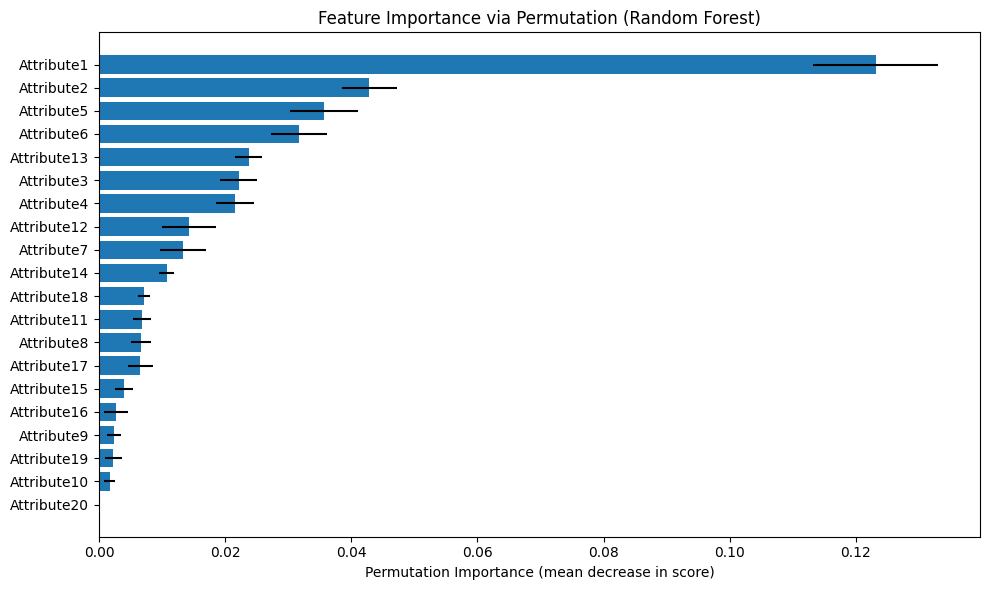

In [26]:
perm_df_sorted = perm_df.sort_values(by='Importance Mean', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(perm_df_sorted['Feature'], perm_df_sorted['Importance Mean'], xerr=perm_df_sorted['Importance Std'])
plt.xlabel('Permutation Importance (mean decrease in score)')
plt.title('Feature Importance via Permutation (Random Forest)')
plt.tight_layout()
plt.show()


## Kneighbors

In [27]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [28]:
y_pred_knn = knn.predict(X_test)

In [29]:
print('KNeighbors model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_knn)))

KNeighbors model accuracy score: 0.6767


In [30]:
from sklearn.inspection import permutation_importance

result = permutation_importance(knn, X_train, y_train, n_repeats=10, random_state=42)

# View the results
import pandas as pd

perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

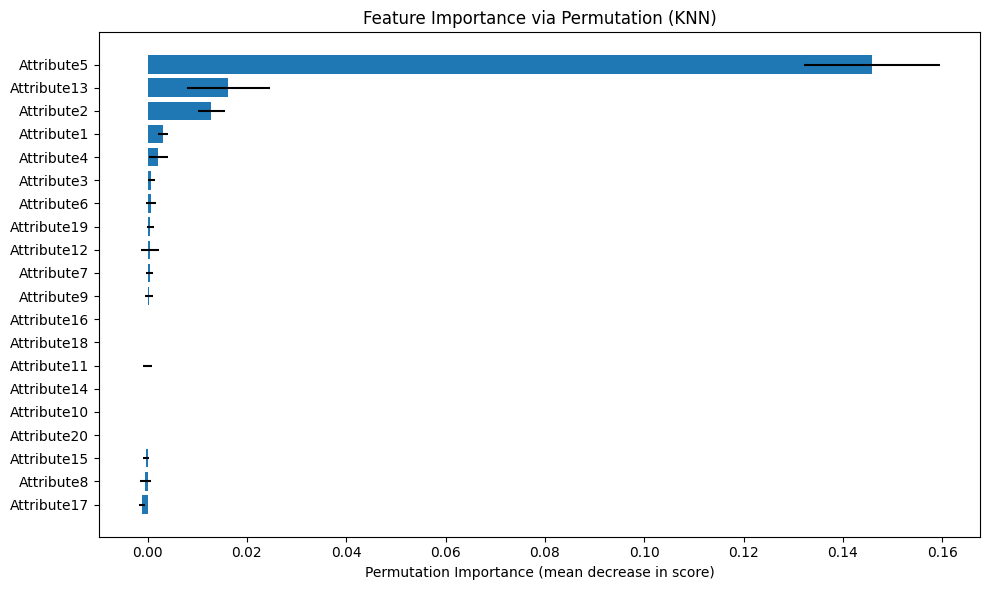

In [31]:
perm_df_sorted = perm_df.sort_values(by='Importance Mean', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(perm_df_sorted['Feature'], perm_df_sorted['Importance Mean'], xerr=perm_df_sorted['Importance Std'])
plt.xlabel('Permutation Importance (mean decrease in score)')
plt.title('Feature Importance via Permutation (KNN)')
plt.tight_layout()
plt.show()
